## Infraestructuras Computacionales para el Procesamiento de Datos Masivos
### Práctica del Módulo 2: Procesamiento paralelo basado en memoria con Apache Spark
### Autor: Jesús Galán Llano
#### Correo: jgalan279@alumno.uned.es

##### Parte 1: Uso de Spark para análisis de datos, Dataframes

Esta primera parte de la práctica consiste en utilizar PySpark para realizar procesamientos sobre un conjunto de datos proporcionado.
En primer lugar, se importan las librerías necesarias. En este caso solamente se van a utilizar la librería SparkSession que permite utilizar los objetos SparkSession y SparkContext necesarios para realizar cualquier procesamiento de datos. Además, también se importa la librería functions que proporciona una serie de funciones útiles para el tratamiento de datos.

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('pt2').getOrCreate()
sc = spark.sparkContext

21/12/10 01:43:59 WARN Utils: Your hostname, jesus-Aspire-A514-52 resolves to a loopback address: 127.0.1.1; using 192.168.1.54 instead (on interface wlp2s0)
21/12/10 01:43:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/10 01:43:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Se debe mencionar que la versión de Spark que se ha empleado es la 3.2.0. Esto es debido a que la versión de Python utilizada es la 3.8.10, que es la versión más reciente compatible con la versión de Spark mencionada. Para el desarrollo de esta práctica se ha creado un entorno virtual para facilitar la gestión de las dependecias de Python.

In [2]:
print(f'Running Spark Version {sc.version}')

from pyspark.conf import SparkConf
conf = SparkConf()
print(conf.toDebugString())

Running Spark Version 3.2.0
spark.app.name=pt2
spark.master=local[*]
spark.submit.deployMode=client
spark.submit.pyFiles=
spark.ui.showConsoleProgress=true


El primer paso consiste en cargar el conjunto de datos en un DataFrame de Spark. Como los datos de entrada están en formato csv utilizamos la función read.csv. Además, indicamos que elimine aquellas filas que no tengan el formato correcto de este tipo de archivos, que el esquema de datos se genera automáticamente y que el fichero contiene el nombre de las columnas. Inferir el esquema es una forma útil y rápida para comenzar a trabajar con los datos, pero requiere revisar qué tipos de datos se han determinado para cada columna.

In [3]:
df = spark.read.csv('dataset_descriptor.csv', mode="DROPMALFORMED", inferSchema=True, header=True)

Mostrar el schema heredado


In [4]:
df.printSchema()

root
 |-- ip_proto: double (nullable = true)
 |-- ip_len_mean: double (nullable = true)
 |-- ip_len_median: double (nullable = true)
 |-- ip_len_var: double (nullable = true)
 |-- ip_len_std: double (nullable = true)
 |-- ip_len_entropy: double (nullable = true)
 |-- ip_len_cv: double (nullable = true)
 |-- ip_len_cvq: double (nullable = true)
 |-- ip_len_rte: double (nullable = true)
 |-- ip_ttl_mean: double (nullable = true)
 |-- ip_ttl_median: double (nullable = true)
 |-- ip_ttl_var: double (nullable = true)
 |-- ip_ttl_std: double (nullable = true)
 |-- ip_ttl_entropy: double (nullable = true)
 |-- ip_ttl_cv: double (nullable = true)
 |-- ip_ttl_cvq: double (nullable = true)
 |-- ip_ttl_rte: double (nullable = true)
 |-- sport_mean: double (nullable = true)
 |-- sport_median: double (nullable = true)
 |-- sport_var: double (nullable = true)
 |-- sport_std: double (nullable = true)
 |-- sport_entropy: double (nullable = true)
 |-- sport_cv: double (nullable = true)
 |-- sport_cvq: 

Mostrar el número de registros del dataframe


In [5]:
df.count()

45500

Q1. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label1?

Para responder a este pregunta primero obtenemos el subconjunto de datos relativo a la columna label1. Seguidamente, utilizamos la función distinct para obtener todos los elementos evitando los repetidos. 

In [6]:
df.select(df['label1'])\
    .distinct()\
        .show()

+-----------------+
|           label1|
+-----------------+
|       http_flood|
|   http_slow_body|
|  http_slow_range|
|           normal|
|   http_slow_read|
|http_slow_headers|
|    tcp_ack_flood|
|    tcp_fin_flood|
|tcp_syn_ack_flood|
|        udp_flood|
|    tcp_syn_flood|
+-----------------+



Q2. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label3?

La manera de proceder con esta cuestión es idéntica que la pregunta anterior, solo que se modifica la columna sobre la que operar.


In [7]:
df.select(df['label3'])\
    .distinct()\
        .show()

+----------+
|    label3|
+----------+
|http_flood|
|    normal|
| http_slow|
| tcp_flood|
| udp_flood|
+----------+



Q3 ¿Que porcentaje de tráfico está catalogado como anormal? Entiendase por anormal aquel que no está etiquetado como normal. Los resultados para label1 y para label3 son idénticos

Para resolver esta pregunta primero utilizamos el método filter que permite hacer una selección de los datos que cumplen una serie de condiciones. En este caso tenemos que filtrar el tráfico cuyo valor para la columna label1 sea distinto de normal. Tras esto, utilizamos la función count para calcular el número de filas de tráfico normal y el número total de filas del dataset. Con estos dos datos se realiza el cálculo del porcentaje.

In [8]:
round(df.filter(df['label1'] != 'normal').count()\
         / df.count() * 100\
             , 2)

49.26

Q4 Mostrar los porcentajes de trafico sobre el total asociados a cada tipo de etiqueta de tráfico (usar el campo genérico Label3 y no el detallado Label 1). Mostrar un diagrama con estos porcentajes (bar plot)

En primer lugar, se agrupan los datos utilizando el campo label3 con la función groupBy. Seguidamente, se utiliza la función count para contar cuántos datos hay en cada etiqueta de tráfico. Para calcular el porcentaje se crea una nueva columna, percentage, y se utiliza el dato anterior y la cantidad de filas del dataset. Para evitar calcular más de una vez el número de filas se ha calculado antes este valor y se ha guardado en una variable. Por último, seleccionamos solamente los camopos que nos interesan con la función select.


In [9]:

total_traffic = df.count()

df.groupBy(df['label3'])\
    .count() \
        .withColumnRenamed('count', 'count_renamed') \
            .withColumn('percentage', F.round(F.col('count_renamed') / total_traffic * 100, scale=4)) \
                .select('label3', 'percentage') \
                    .show()

+----------+----------+
|    label3|percentage|
+----------+----------+
|http_flood|    0.7626|
|    normal|   50.7429|
| http_slow|    0.4022|
| tcp_flood|   32.9407|
| udp_flood|   15.1516|
+----------+----------+



Para mostrar los resultados de forma gráfica utilizamos la librería matplotlib. Con el fin de guardar los resultados en una variable utilizamos el método collect. 

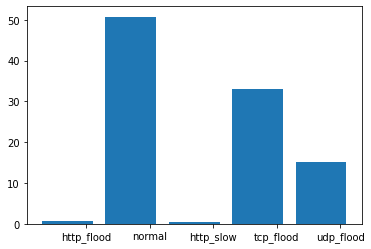

In [10]:
import matplotlib.pyplot as plt

q4 = df.groupBy(df['label3'])\
    .count() \
        .withColumnRenamed('count', 'count_renamed') \
            .withColumn('percentage', F.round(F.col('count_renamed') / total_traffic * 100, scale=4)) \
                .select('label3', 'percentage') \
                    .collect()

indexes = list(range(len(q4)))
values = [r['percentage'] for r in q4]
labels = [r['label3'] for r in q4]

plt.bar(indexes, values)
labelidx = [i + 0.3 for i in indexes] 
plt.xticks(labelidx, labels)
plt.show()

Q5 Identificar que tipo de tráfico de red está incluido en el dataset (usar el campo ip_proto y convertir ese valor al real que debería tener, es decir, un entero en el rango definido por el IANA) https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

Para responder a esta pregunta primero seleccionamos solamente la columna que nos interesa, ip_proto, eliminando lo elementos duplicados. Una vez hecho esto, convertimos el dato al tipo de dato correcto especificado por el IANA, es decir, un número entero. Para ello multiplicamos este valor por 1000 y utilizamos la función cast para convertilo a entero. Finalmente, obtenemos dos resultados: 17, que identifica el tráfico TCP, y 6, que se corresponde con el tráfico UDP.

In [11]:

df.select('ip_proto')\
    .distinct()\
        .withColumn('ip_proto_int', (df["ip_proto"] * 1000).cast("int"))\
            .select('ip_proto_int')\
                .show()

+------------+
|ip_proto_int|
+------------+
|          17|
|           6|
+------------+



Para evitar tener que hacer este cálculo en las consultas siguientes se actualiza el DataFrame creando una nueva columna, ip_proto_int, que contiene el valor correcto de tipo entero.

In [12]:
df = df.withColumn('ip_proto_int', (df["ip_proto"] * 1000).cast("int"))


Q6 Calcular la cantidad total (suponer que el dato a aculumar para cada paquete es ip_len_mean) de bytes transmitidos agrupados por protocolo.

En primer lugar, utilizamos la función groupBy para agrupar los datos respecto al nuevo campo ip_proto_int. Una vez hecho esto, empleamos la función sum para que calcule el sumatorio del campo ip_len_mean. Por último, seleccionamos solamente estas dos columnas.

In [13]:

df.groupBy(df['ip_proto_int'])\
    .sum('ip_len_mean')\
        .select('ip_proto_int', 'sum(ip_len_mean)')\
            .show()

+------------+-----------------+
|ip_proto_int| sum(ip_len_mean)|
+------------+-----------------+
|           6| 26867.1914740567|
|          17|7064.346040678178|
+------------+-----------------+



Q7 Indicar cual es tráfico anómalo en UDP que usa más tráfico de red.Presentar los resultados en orden de mayor a menor.

Para conestar a esta pregunta primero se realiza un filtrado de los datos utilizando la función filter seleccionando solamente el tráfico UDP. Seguidamente, se agrupan los resultados utilizando el campo label1 y se calcula el sumatorio del campo ip_len_mean. Finalmente, se utiliza la función desc para ordenar los resultados de mayor a menor tráfico de red.


In [14]:
df.filter(df['ip_proto_int'] == 17)\
    .groupBy('Label1').agg(F.sum('ip_len_mean').alias('sum_ip_len_mean'))\
        .orderBy(F.desc('sum_ip_len_mean'))\
            .show()

+---------+------------------+
|   Label1|   sum_ip_len_mean|
+---------+------------------+
|udp_flood|            6894.0|
|   normal|170.34604067817844|
+---------+------------------+



Q8 Indicar cual es tráfico anómalo en TCP que usa más tráfico de red. Presentar los resultados en orden de mayor a menor

El razonamiento de esta pregunta es idéntica a la pregunta anterior, salvo que se modifica el filtro inicial. En este caso se selecciona el tráfico TCP.

In [15]:
df.filter((df['ip_proto_int'] == 6))\
    .groupBy('Label1').agg(F.sum('ip_len_mean').alias('sum_ip_len_mean'))\
        .orderBy(F.desc('sum_ip_len_mean'))\
            .show()

+-----------------+------------------+
|           Label1|   sum_ip_len_mean|
+-----------------+------------------+
|           normal|11615.053998509025|
|    tcp_syn_flood| 5713.195544936026|
|tcp_syn_ack_flood| 5273.157952268173|
|    tcp_ack_flood|            2000.0|
|    tcp_fin_flood|            2000.0|
|       http_flood| 90.88054677859463|
|  http_slow_range| 44.20993791090954|
|http_slow_headers|44.157370741482964|
|   http_slow_read|43.283366733466934|
|   http_slow_body|43.252756179024715|
+-----------------+------------------+



##### Parte 2: Uso de Spark para análisis de datos, Spark SQL

Esta segunda parte de la práctica consiste en contestar a las cuestiones anteriores, pero esta vez empleando Spark SQL.

En primer lugar, se importan las librerías necesarias y se crean los objetos SparkSession y SparkContext.

In [16]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('pt2').getOrCreate()
sc = spark.sparkContext

Seguidamente, leemos el dataset de la misma forma que en el primer apartado y analizamos el esquema de datos que se ha inferido.


In [17]:
df = spark.read.csv('dataset_descriptor.csv', mode="DROPMALFORMED", inferSchema=True, header=True)

df.printSchema()


root
 |-- ip_proto: double (nullable = true)
 |-- ip_len_mean: double (nullable = true)
 |-- ip_len_median: double (nullable = true)
 |-- ip_len_var: double (nullable = true)
 |-- ip_len_std: double (nullable = true)
 |-- ip_len_entropy: double (nullable = true)
 |-- ip_len_cv: double (nullable = true)
 |-- ip_len_cvq: double (nullable = true)
 |-- ip_len_rte: double (nullable = true)
 |-- ip_ttl_mean: double (nullable = true)
 |-- ip_ttl_median: double (nullable = true)
 |-- ip_ttl_var: double (nullable = true)
 |-- ip_ttl_std: double (nullable = true)
 |-- ip_ttl_entropy: double (nullable = true)
 |-- ip_ttl_cv: double (nullable = true)
 |-- ip_ttl_cvq: double (nullable = true)
 |-- ip_ttl_rte: double (nullable = true)
 |-- sport_mean: double (nullable = true)
 |-- sport_median: double (nullable = true)
 |-- sport_var: double (nullable = true)
 |-- sport_std: double (nullable = true)
 |-- sport_entropy: double (nullable = true)
 |-- sport_cv: double (nullable = true)
 |-- sport_cvq: 

Seguidamente, registramos el DataFrame como una tabla y creamos una vista temporal para trabajar sobre ella.

In [18]:
df.registerTempTable("cyberattacks")

df.createOrReplaceTempView("cyberattacks")

/home/jesus/universidad/Infraestructuras_Computacionales/practicas/TP2/sparkenv/lib/python3.8/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(
21/12/10 01:44:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Q1. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label1?

Para contestar a esta pregunta utilizamos el operador DISTINCT para eliminar los datos duplicados.

In [19]:
sql_statement = "SELECT DISTINCT Label1 FROM cyberattacks"
sparksql_q1 = spark.sql(sql_statement)
sparksql_q1.show()

+-----------------+
|           Label1|
+-----------------+
|       http_flood|
|   http_slow_body|
|  http_slow_range|
|           normal|
|   http_slow_read|
|http_slow_headers|
|    tcp_ack_flood|
|    tcp_fin_flood|
|tcp_syn_ack_flood|
|        udp_flood|
|    tcp_syn_flood|
+-----------------+



Q2. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label3?

Esta pregunta tiene el mismo razonamiento anterior, salvo que se ejecuta sobre el campo label3.

In [20]:
sql_statement = "SELECT DISTINCT label3 from cyberattacks"
sparksql_q2 = spark.sql(sql_statement)
sparksql_q2.show()

+----------+
|    label3|
+----------+
|http_flood|
|    normal|
| http_slow|
| tcp_flood|
| udp_flood|
+----------+



Q3 ¿Que porcentaje de tráfico está catalogado como anormal? Entiendase por anormal aquel que no está etiquetado como normal.

Para conestar a esta pregunta realizamos un primer filtro para obtener el tráfico distinto del normal. Seguidamente, utilizamos la función count para obtener el número de filas que tienen un tráfico normal y calculamos el porcentaje sobre el total de filas.

In [21]:
sql_statement = "SELECT ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM cyberattacks), 2) AS percentage_traffic_not_normal \
    FROM cyberattacks \
        WHERE label1 != 'normal';" \

sparksql_q3 = spark.sql(sql_statement)
sparksql_q3.show()

+-----------------------------+
|percentage_traffic_not_normal|
+-----------------------------+
|                        49.26|
+-----------------------------+



Q4 Mostrar los porcentajes de trafico sobre el total asociados a cada tipo de etiqueta de tráfico (usar el campo genérico Label3 y no el detallado Label 1).Mostrar un diagrama con estos porcentajes (bar plot)

Para responder a esta pregunta agrupamos los datos a través de la función GROUP BY utilizando el campo label3. Tras esto, calculamos el total de cada tipo de tráfico junto con el tráfico total para obtener su porcentaje correspondiente.

In [22]:

sql_statement = "SELECT label3, ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM cyberattacks), 4) AS percentage_traffic_not_normal \
    FROM cyberattacks \
        GROUP BY label3;"

sparksql_q4 = spark.sql(sql_statement)
sparksql_q4.show()

+----------+-----------------------------+
|    label3|percentage_traffic_not_normal|
+----------+-----------------------------+
|http_flood|                       0.7626|
|    normal|                      50.7429|
| http_slow|                       0.4022|
| tcp_flood|                      32.9407|
| udp_flood|                      15.1516|
+----------+-----------------------------+



Para mostrar los resultados de forma gráfica utilizamos la librería matplotlib. Se debe convertir el DataFrame a un DataFrame de pandas para poder visualizarlo.

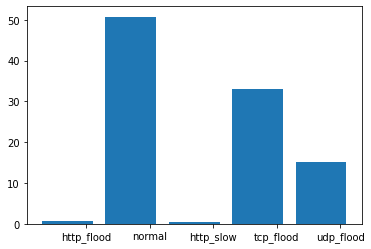

In [23]:
indexes = list(range(len(sparksql_q4.toPandas())))
values = [r['percentage'] for r in q4]
labels = [r['label3'] for r in q4]

plt.bar(indexes, values)
labelidx = [i + 0.3 for i in indexes] 
plt.xticks(labelidx, labels)
plt.show()

Q5 Identificar que tipo de tráfico de red está incluido en el dataset (usar el campo ip_proto y convertir ese valor al real que debería tener, es decir, un entero en el rango definido por el IANA)
https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

Para contestar a esta pregunta utilizamos la función distinct para obtener los distintos protocolos. Una vez obtenidos, multiplicamos su valor por 1000 y convertimos el resultado a entero.

In [24]:

sql_statement = "select distinct CAST(ip_proto * 1000 AS int) AS ip_proto_int \
    from cyberattacks;" \

sparksql_q5 = spark.sql(sql_statement)
sparksql_q5.show()

+------------+
|ip_proto_int|
+------------+
|           6|
|          17|
+------------+



Para evitar volver a calcular este valor en las futuras consultas, se crea un nuevo dataset con todas las columnas anteriores más una nueva columna con el valor correcto del campo ip_proto. También se registra de nuevo la tabla y se crea una nueva vista.


In [25]:
df = df.withColumn('ip_proto_int', (df["ip_proto"] * 1000).cast("int"))
# Registrar la tabla
df.registerTempTable("cyberattacks_updated")
df.createOrReplaceTempView("cyberattacks_updated")
df.show(n=5, truncate=True, vertical=True)

-RECORD 0----------------------------------
 ip_proto            | 0.006               
 ip_len_mean         | 0.262966611188479   
 ip_len_median       | 0.110169491525424   
 ip_len_var          | 0.0890553991458792  
 ip_len_std          | 0.298421512538689   
 ip_len_entropy      | 0.00350492747587452 
 ip_len_cv           | 1.0                 
 ip_len_cvq          | 0.772428884026258   
 ip_len_rte          | 0.128256513026052   
 ip_ttl_mean         | 0.262966611188479   
 ip_ttl_median       | 0.110169491525424   
 ip_ttl_var          | 0.0890553991458792  
 ip_ttl_std          | 0.298421512538689   
 ip_ttl_entropy      | 0.00350492747587452 
 ip_ttl_cv           | 1.0                 
 ip_ttl_cvq          | 0.772428884026258   
 ip_ttl_rte          | 0.128256513026052   
 sport_mean          | 0.996074644258336   
 sport_median        | 0.998106284767428   
 sport_var           | 1.89306485398115E-5 
 sport_std           | 0.00435093651296034 
 sport_entropy       | 0.0078395

Q6 Calcular la cantidad total (suponer que el dato a aculumar para cada paquete es ip_len_mean) de bytes transmitidos agrupados por protocolo.

Para responder a esta pregunta utilizamos el método GROUP BY para agrupar los datos en base a su protocolo. Tras esto, utilizamos la función SUM para calcular el sumatorio de la columna ip_lean_mean.

In [26]:

sql_statement = "SELECT ip_proto_int, SUM(ip_len_mean) \
    FROM cyberattacks_updated \
        GROUP BY ip_proto_int;"

sparksql_q6 = spark.sql(sql_statement)
sparksql_q6.show()

+------------+-----------------+
|ip_proto_int| sum(ip_len_mean)|
+------------+-----------------+
|           6| 26867.1914740567|
|          17|7064.346040678178|
+------------+-----------------+



Q7 Indicar cual es tráfico anómalo en UDP que usa más tráfico de red. Presentar los resultados en orden demayor a menor

En primer lugar, filtramos el tráfico seleccionando solamente el tráfico UDP. Tras esto, agrupamos los datos en base al campo label1 y calculamos el sumatorio de la columna ip_len_mean. Finalmente, ordenamos los resultados de mayor a menor tráfico.

In [27]:
sql_statement = "SELECT label1, SUM(ip_len_mean) AS sum_ip_len_mean \
    FROM cyberattacks_updated \
        WHERE ip_proto_int == 17 \
            GROUP BY label1 \
                ORDER BY sum_ip_len_mean DESC;"

sparksql_q7 = spark.sql(sql_statement)
sparksql_q7.show()

+---------+------------------+
|   label1|   sum_ip_len_mean|
+---------+------------------+
|udp_flood|            6894.0|
|   normal|170.34604067817844|
+---------+------------------+



Q8 Indicar cual es tráfico anómalo en TCP que usa más tráfico de red. Presentar los resultados en orden demayor a menor

El razonamiento de esta pregunta es el mismo que para la pregunta anterior, salvo que se filta por el tráfico TCP.


In [28]:
sql_statement = "SELECT label1, SUM(ip_len_mean) AS sum_ip_len_mean \
    FROM cyberattacks_updated \
        WHERE ip_proto_int == 6 \
            GROUP BY label1 \
                ORDER BY sum_ip_len_mean DESC;"

sparksql_q8 = spark.sql(sql_statement)
sparksql_q8.show()

+-----------------+------------------+
|           label1|   sum_ip_len_mean|
+-----------------+------------------+
|           normal|11615.053998509025|
|    tcp_syn_flood| 5713.195544936026|
|tcp_syn_ack_flood| 5273.157952268173|
|    tcp_ack_flood|            2000.0|
|    tcp_fin_flood|            2000.0|
|       http_flood| 90.88054677859463|
|  http_slow_range| 44.20993791090954|
|http_slow_headers|44.157370741482964|
|   http_slow_read|43.283366733466934|
|   http_slow_body|43.252756179024715|
+-----------------+------------------+



Por último, se finaliza la sesión de Spark para liberar los recursos utilizados.

In [29]:
spark.stop()